In [1]:
# ライブラリーの読み込み
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import datasets
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from sklearn.metrics import mean_absolute_error
from statistics import mean 
from matplotlib import pyplot as plt
# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

In [2]:
# データの読み込み
data = datasets.load_wineind()

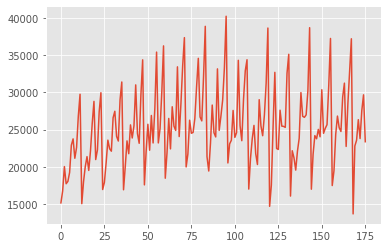

In [3]:
# グラフ（折れ線）
plt.plot(data)

In [4]:
data

array([15136., 16733., 20016., 17708., 18019., 19227., 22893., 23739.,
       21133., 22591., 26786., 29740., 15028., 17977., 20008., 21354.,
       19498., 22125., 25817., 28779., 20960., 22254., 27392., 29945.,
       16933., 17892., 20533., 23569., 22417., 22084., 26580., 27454.,
       24081., 23451., 28991., 31386., 16896., 20045., 23471., 21747.,
       25621., 23859., 25500., 30998., 24475., 23145., 29701., 34365.,
       17556., 22077., 25702., 22214., 26886., 23191., 27831., 35406.,
       23195., 25110., 30009., 36242., 18450., 21845., 26488., 22394.,
       28057., 25451., 24872., 33424., 24052., 28449., 33533., 37351.,
       19969., 21701., 26249., 24493., 24603., 26485., 30723., 34569.,
       26689., 26157., 32064., 38870., 21337., 19419., 23166., 28286.,
       24570., 24001., 33151., 24878., 26804., 28967., 33311., 40226.,
       20504., 23060., 23562., 27562., 23940., 24584., 34303., 25517.,
       23494., 29095., 32903., 34379., 16991., 21109., 23740., 25552.,
      

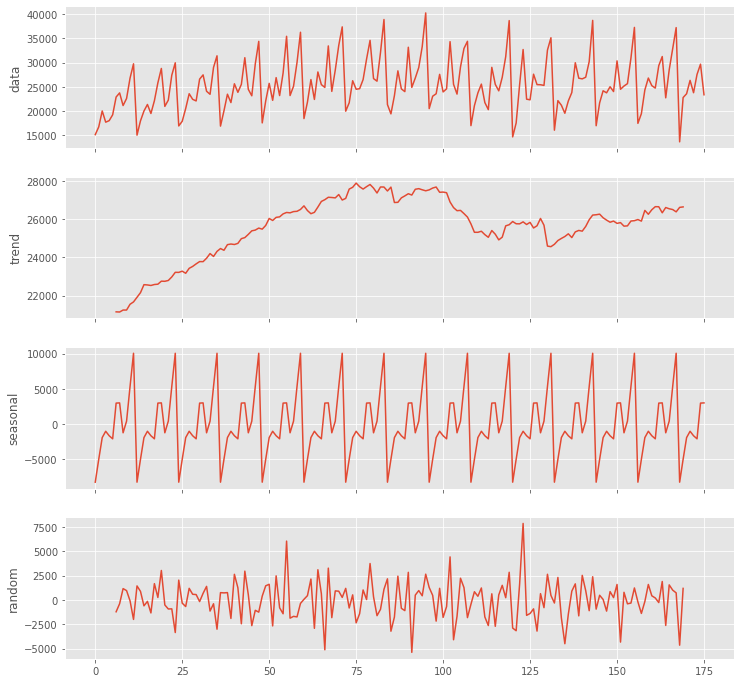

In [6]:
# 要素分解（tread・seasonal・random）
utils.decomposed_plot(arima.decompose(data,'additive',m=12),
                      figure_kwargs = {'figsize': (12, 12)} )

/home/hajime/.local/lib/python3.8/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


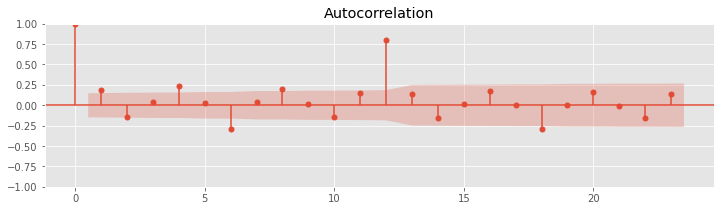

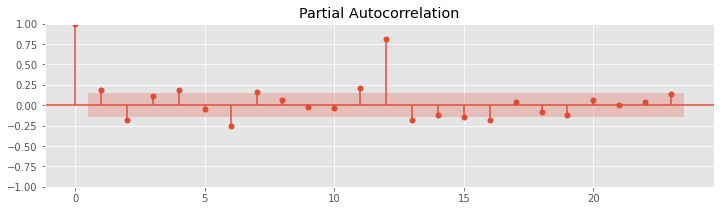

In [7]:
# グラフのサイズ変更
plt.rcParams['figure.figsize'] = [12, 3]
# 自己相関と偏自己相関
utils.plot_acf(data, alpha=.05)
utils.plot_pacf(data, alpha=.05)
 

In [8]:
# 階差の次数の検討
print('d =', arima.ndiffs(data)) #d（階差）
print('D =', arima.nsdiffs(data,m=12)) #D（季節階差）


d = 1
D = 1


In [9]:
# 通常の階差処理を1回しさらに季節階差処理を1回
data_d1_d12 = pd.DataFrame(data).diff(1).diff(12).dropna()

In [10]:
data_d1_d12

,0
13,1352.0
14,-1252.0
15,3654.0
16,-2167.0
17,1419.0
...,...
171,305.0
172,-975.0
173,4271.0
174,-2510.0


In [11]:
# データ分割（train:学習データ、test:テストデータ）
train, test = model_selection.train_test_split(data, train_size=140)

In [12]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(train, 
                            seasonal=True,
                            m=12,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

/home/hajime/.local/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2722.388, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2841.881, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2757.441, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2748.415, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2839.907, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2738.625, Time=0.96 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2721.415, Time=0.47 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2783.069, Time=0.11 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2721.700, Time=1.39 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2723.699, Time=1.35 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=2730.711, Time=0.24 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=2717.391, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=2781.020, Time=0.09 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=2717.703, Time=1.44 sec
 ARIMA(2,1,1)(1,0,1

MAE:
2614.4492431988006
MAPE(%):
9.788931876578925


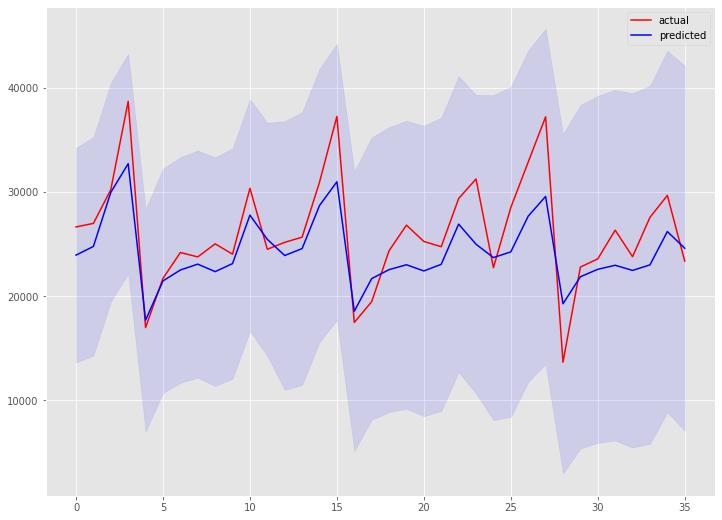

In [13]:
# グラフのサイズ変更
plt.rcParams['figure.figsize'] = [12, 9]
# 予測
preds, conf_int = arima_model.predict(n_periods=test.shape[0], 
                                      return_conf_int=True)
# 予測精度
print('MAE:')
print(mean_absolute_error(test, preds)) 
print('MAPE(%):')
print(mean(abs(test - preds)/test) *100)
# 予測と実測の比較（グラフ）
x_axis = np.arange(preds.shape[0])
plt.plot(x_axis,test,label="actual",color='r') 
plt.plot(x_axis,preds,label="predicted",color='b')
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()
 

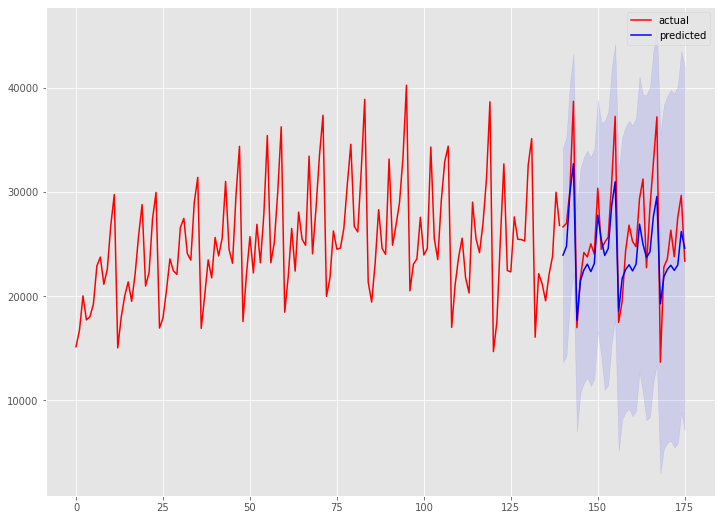

In [14]:
# グラフ（学習データとテストデータ、予測結果）
x_axis = np.arange(train.shape[0] + preds.shape[0])
plt.plot(x_axis[:train.shape[0]],train,color='r',label="actual")
plt.plot(x_axis[train.shape[0]:],test,color='r')
plt.plot(x_axis[train.shape[0]:],preds,color='b',label="predicted")
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1,color='b')
plt.legend()
plt.show()
 

/home/hajime/.local/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


MAE:
1879.1081537970495
MAPE(%):
7.405348657534772


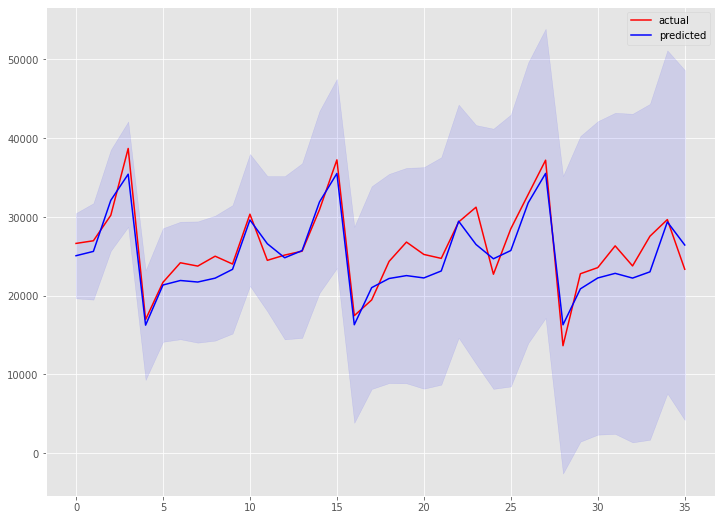

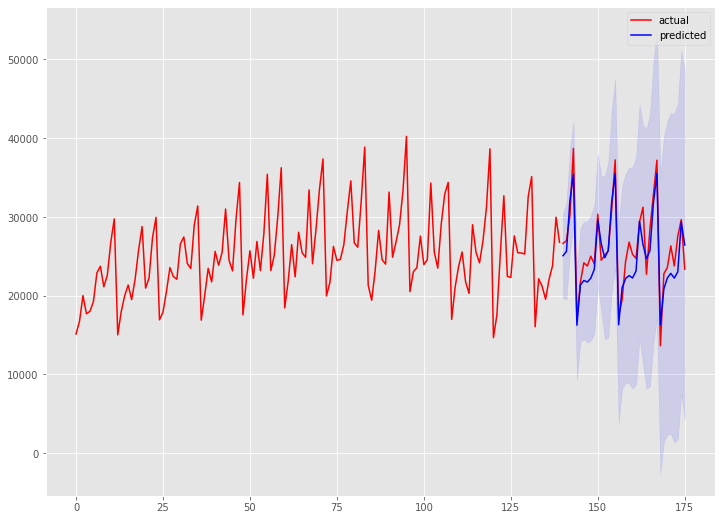

In [15]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(train, 
                             seasonal=True,
                             m=12,
                             d=1,
                             D=1,
                             n_jobs=-1,
                             maxiter=10)
# グラフのサイズ変更
plt.rcParams['figure.figsize'] = [12, 9]
# 予測
preds, conf_int = arima_model.predict(n_periods=test.shape[0], 
                                      return_conf_int=True)
# 予測精度
print('MAE:')
print(mean_absolute_error(test, preds)) 
print('MAPE(%):')
print(mean(abs(test - preds)/test) *100)
# 予測と実測の比較（グラフ）
x_axis = np.arange(preds.shape[0])
plt.plot(x_axis,test,label="actual",color='r') 
plt.plot(x_axis,preds,label="predicted",color='b')
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()
# グラフ（学習データとテストデータ、予測結果）
x_axis = np.arange(train.shape[0] + preds.shape[0])
plt.plot(x_axis[:train.shape[0]],train,color='r',label="actual")
plt.plot(x_axis[train.shape[0]:],test,color='r')
plt.plot(x_axis[train.shape[0]:],preds,color='b',label="predicted")
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1,color='b')
plt.legend()
plt.show()